In [1]:
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import time

from BCJR import BCJR
from RLL_BCJR import RLL_BCJR
from rll_encoding import rllEncoderFct
from rll_encoding import nrziEncodingFct

#python debugger
import pdb

In [2]:
def rc_filter(roll_off, filter_length, sampling_freq):
    t = np.linspace(-filter_length/2, filter_length/2, num=(filter_length*sampling_freq+1))
    rc = np.piecewise(t, [t==0, np.abs(t) == 1/float(2*roll_off), (t!=0) & (np.abs(t) != 1/float(2*roll_off))], [lambda t:1,  
                        lambda t: np.pi/4*np.sin(np.pi/(2*roll_off))/(np.pi/(2*roll_off)), 
                        lambda t:np.sin(np.pi*t)/(np.pi*t)*np.cos(roll_off*np.pi*t)/(1-(2*roll_off*t)**2)])

    #matlab normailzes the result, s.t. the sum of the squared samples is one
    power = np.sum(rc**2)
    rc /= np.sqrt(power)
    return rc

#the noise must be convolved with only one filter
def rrc_filter(roll_off, filter_length, sampling_freq):
    t = np.linspace(-filter_length/2, filter_length/2, num=(filter_length*sampling_freq+1))
    rrc = np.piecewise(t, [t==0, np.abs(t) == 1/float(4*roll_off), (t!=0) & (np.abs(t) != 1/float(4*roll_off))], [
                        lambda t:(1-roll_off+4*roll_off/np.pi), 
                        lambda t: roll_off/np.sqrt(2)*((1+2/np.pi)*np.sin(np.pi/(4*roll_off))+(1-2/np.pi)*np.cos(np.pi/(4*roll_off))),
                        lambda t: (np.sin(np.pi*t*(1-roll_off))+4*roll_off*t*np.cos(np.pi*t*(1+roll_off)))/(np.pi*t*(1-(4*roll_off*t)**2))])


    #matlab normailzes the result, s.t. the sum of the squared samples is one
    power = np.sum(rrc**2)
    rrc /= np.sqrt(power)
    return rrc


In [3]:
def evalCodedBERBcjrFct(seed, ebno, N, M, span, rolloff, rllD, corrType, fecR, numSim, minNumErr):
    start = time.time()
    trellis = {'numInputSymbols': 2, 'numOutputSymbols': 4,
               'numStates': 4, 'nextStates': np.array([[2,3],[0,2],[0,1],[2,3]]),
               'outputs': np.array([["00","00"],["01","00"],["01","10"],["00","00"]]),
               'fromStates': [[1,2,np.inf, np.inf],[2,np.inf, np.inf, np.inf],[0, 1, 3, np.inf],[0, 3, np.inf, np.inf]]}

    rllR = 1/2
    rllD = 2
    
    seqLen = 11264 
    
    omega = int(N/M)
    L = span*N
    K = span*M

    v = rc_filter(rolloff,span,N)
    g = rrc_filter(rolloff,span,N)
    V = np.matlib.repmat(v,omega, 1)
    V = np.concatenate((V, np.zeros((omega, omega-1))), axis=1)
    G = np.matlib.repmat(g, omega,1)
    G = np.concatenate((G, np.zeros((omega, omega-1))), axis=1)
    for i in range(1,omega):
        V[i,:] = np.roll(V[i,:],i, axis=0)
        G[i,:] = np.roll(G[i,:],i, axis=0)
    # Obtain upsampling matrix U
    U = np.zeros(((L+2)*omega-1, L+1))
    for i in range((L+2)*omega-1):
        for j in range(L+1):
            if (i+1) == (j+1)*omega:
                U[i,j] = 1
            else:
                U[i,j] = 0
    num_be = 0
    num_bits = 0
    for simulation in range(numSim):
        snrdB  = ebno + 10*np.log10(rllR)
        snrLin = 10**(snrdB/10.0)
        
        rll_bcjr = RLL_BCJR(rllD)
        main_bcjr = BCJR(M, N, span, rolloff, rllD, snrdB, seqLen)
        
        #for debugging purposes
        #bits = sp.io.loadmat('bits.mat')["bits"].flatten()
        
        bits = np.random.choice([0,1],int(seqLen*rllR)).astype("int32")
        #Rll Encoding
        bitsEncRll = rllEncoderFct(bits, trellis)
        x = nrziEncodingFct(bitsEncRll)
        #begin and terminate in a known state
        x = np.append(-1*np.ones(L),x)
        x = np.append(x, np.array([x[-1],x[-1]]))
        x = np.append(x, -1*np.ones(L+1))
        #also for debugging purposes
        #n = sp.io.loadmat('n.mat')["n"].flatten()
        n = np.random.normal(loc=0, scale=1, size=seqLen+2*K+rllD+1)
        outIter = -1
        y = np.zeros(seqLen+2*L+rllD)
        r_debug = np.zeros(seqLen+2*L+rllD)
        
        for i in range(L,seqLen+2*L+rllD+1):
            outIter = outIter + 1

            if corrType == 'corr':
                #Correlated noise
                y[outIter] =  np.sqrt(snrLin)*V@U@x[i-L:i+1] + G@n[i-L:i+1+(K-L)]
            elif corrType =='uncorr':
                #Uncorrelated noise
                y[outIter] =  sqrt(snrLin)*V@U@x[i-L:i+1] + n[i]
                
            r_debug[outIter] = np.sign(y[outIter])
        
        llr = main_bcjr.run(r_debug)
        
        llr_rll = rll_bcjr.run(llr)

        #Rate recovery
        #llr_rll_matched = np.append(llr_rll, np.zeros(fecN-len(llr_rll)))
        #[output_bits, errors] = ldpc.MpDecode(llr_rll_matched, H_rows, H_cols, n_decode_iter, 1)
        #instead of channel-decoding a hard decision is done
        llr_rll[llr_rll >= 0]  = 0
        llr_rll[llr_rll < 0] = 1
        num_be += np.count_nonzero(llr_rll-bits)
        num_bits += num_bits + len(bits)
        
        #early termination
        if num_be > minNumErr:
            break
    ber = num_be/num_bits
    stop = time.time()
    return ber, stop-start

/home/stephan/Dokumente/Studium/SHK Arbeit/Workspace2/Complete/BCJR.py:177: RuntimeWarning: divide by zero encountered in true_divide
  llr = np.log(app[0,:]/app[1,:])
/home/stephan/Dokumente/Studium/SHK Arbeit/Workspace2/Complete/BCJR.py:177: RuntimeWarning: divide by zero encountered in log
  llr = np.log(app[0,:]/app[1,:])
/home/stephan/Dokumente/Studium/SHK Arbeit/Workspace2/Complete/RLL_BCJR.py:111: RuntimeWarning: divide by zero encountered in log
  llrOut = np.log(app[:,0]/app[:,1])
/home/stephan/Dokumente/Studium/SHK Arbeit/Workspace2/Complete/RLL_BCJR.py:111: RuntimeWarning: divide by zero encountered in true_divide
  llrOut = np.log(app[:,0]/app[:,1])


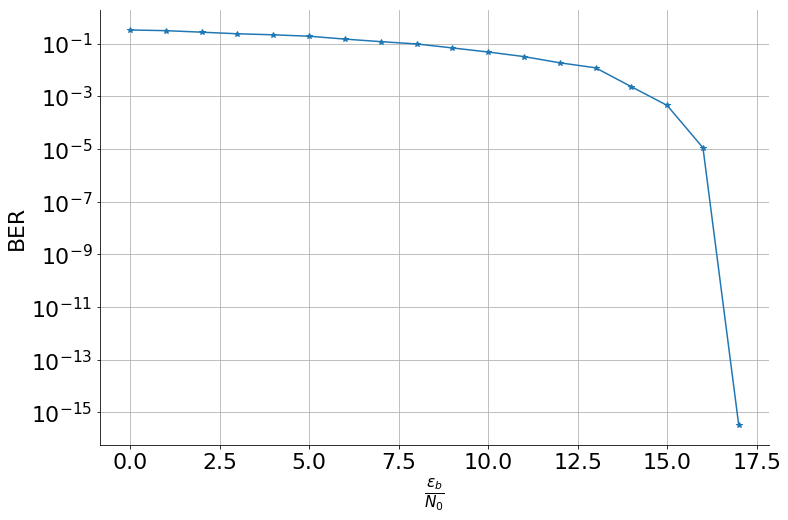

In [11]:
seed = 1234
N = 2
M = 2
span = 2
rolloff = 0.5
rllD = 2
corrType = 'corr'
fecR = 0.5
numSim = 1000
minNumErr = 30
ebno_range = np.linspace(0,17,18)
ebno_ber_list = [[],[]]
for ebno in ebno_range:
    ebno_ber_list[0].append(ebno)
    ebno_ber_list[1].append(evalCodedBERBcjrFct(seed, ebno, N, M, span, rolloff, 
                                                rllD, corrType, fecR, numSim, minNumErr)[0])
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(12,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')
ax.set_ylabel("BER")
ax.set_xlabel(r"$\frac{\varepsilon_b}{N_0}$")
ax.plot(ebno_ber_list[0],ebno_ber_list[1],marker="*")

ax.grid(True,which="both",ls="-")
plt.savefig("simulation_ohne_fec.pdf")
plt.show()

In [8]:
ebno_ber_list

[[0.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0],
 [0.3341619318181818,
  0.31480823863636365,
  0.28675426136363635,
  0.2507102272727273,
  0.22265625,
  0.1875,
  0.15305397727272727,
  0.11825284090909091,
  0.10120738636363637,
  0.06729403409090909,
  0.050603693181818184,
  0.030539772727272728,
  0.0234375,
  0.006924715909090909,
  0.002012310606060606,
  9.864267676767677e-05,
  3.4681182822548873e-07,
  1.2918958832004758e-15,
  9.324581450597767e-24,
  6.110957699463753e-19,
  1.3894709126051913e-31]]